In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import geopandas
import descartes

# Methodology

For this initial EDA assignment, we tried a multitude of methods in order to gain a broader perspective into the data that we were given and what we could glean from an inspection of the data. Much of what we did was informed by the final goal of our project; ultimately, we want to be able to forecast the growth and lifecycle of the virus in various U.S. counties. A related goal is to be able to predict where the next outbreak of the virus may be in order to preemptively instate precautionary policies.

Here, we will briefly discuss the efforts we had done below. 

First, in order to get a sense of how quickly the virus is spreading in any given state/county, we created a function that calculates the growth rate over the past $n$ days. This gives us a naive indication of the severity of the infection in a given place. We anticipate building upon this function in order to gain a better way of forecasting the growth by incorporating global data because there has been no unequivocal evidence of any U.S. region hitting the top of the curve yet. Using our initial function, however, we can already get a comparison of growth rates in a specific region over the previous $n$ days and rank them by severity.

Second, we wanted to experiment with ways of visually representing this data. We came up with two initial approaches: a simple line plot looking at growth rates over time and a geo-map showing the hot spots in a particular state. We want to continue to look for new ways of presenting this data in a clear and powerful way. 


From our EDA, we have been able to get a good sense of what kind of data the CSSE is providing and have identified areas of interest that we want to look into, specifically in terms of augmenting our dataset in order to successfully achieve our goal.



# Process Data

In [39]:
confirmed_df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
deaths_df = pd.read_csv("../csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

In [40]:
confirmed_df.rename(columns={"Admin2": "County"}, inplace=True)
deaths_df.rename(columns={"Admin2": "County"}, inplace=True)

In [41]:
confirmed_df.head()

,UID,iso2,iso3,code3,FIPS,County,Province_State,Country_Region,Lat,Long_,...,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,84,93,112,113,121,121,128,130,133,133
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,6,6,6,6,6,6,6,6,6,6
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,316,452,475,513,573,620,683,725,788,897
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,37,40,42,43,43,45,45,50,51,51


# Examining Growth Rates

## Create last_n_day_growth_rate

In [42]:
def avg_growth_rate_last_n_days(df, n_days):
    last_n_days = df.values[:, -n_days:]
    try:
        last_n_days = last_n_days.astype("int")
    except:
        raise Exception("Incorrectly specified number of days")
    
    delta_list = []
    for i in range(n_days-1):
        delta = (last_n_days[:,i+1] - last_n_days[:,i]) / np.maximum(last_n_days[:,i], 1)
        delta_list.append(delta)
    
    return np.mean(delta_list, axis=0)

## Use to Examine California

In [43]:
CA_df = confirmed_df.loc[confirmed_df['Province_State'] == "California"].copy()

In [44]:
ca_growth_last_3_days = avg_growth_rate_last_n_days(CA_df, 3)

In [45]:
CA_df["Location"] = "S"
CA_df.loc[CA_df["Lat"] > 36, "Location"] = "N"

In [46]:
CA_df['ROC'] = ca_growth_last_3_days

In [47]:
sorted_by_severity = CA_df.sort_values(by=["ROC"], ascending=False)

In [48]:
thresh = 20
sorted_by_severity.loc[sorted_by_severity["4/12/20"] > thresh, ["County", "ROC", "Location"]].head(20)

,County,ROC,Location
214,Merced,0.118155,N
247,Yolo,0.114836,N
223,Riverside,0.095688,S
240,Stanislaus,0.084659,N
205,Kern,0.084138,S
200,Fresno,0.078201,N
217,Monterey,0.075325,N
220,Orange,0.059400,S
244,Tulare,0.059113,N
226,San Bernardino,0.055556,S


## Look at the whole US

In [49]:
national_growth_last_3_days = avg_growth_rate_last_n_days(confirmed_df, 3)
confirmed_df.insert(2, "ROC", national_growth_last_3_days)

In [50]:
nat_sorted_by_severity = confirmed_df.sort_values(by=["ROC"], ascending=False)
thresh = 1000
nat_sorted_by_severity.loc[nat_sorted_by_severity["4/12/20"] > thresh, ["County", "Province_State", "ROC", "4/12/20"]].head(20)

,County,Province_State,ROC,4/12/20
3231,Unassigned,New Jersey,0.401258,1274
2254,Berks,Pennsylvania,0.202285,1035
2319,Providence,Rhode Island,0.169110,1278
2853,Fairfax,Virginia,0.141521,1008
2451,Davidson,Tennessee,0.137168,1349
1230,Middlesex,Massachusetts,0.128655,5660
251,Arapahoe,Colorado,0.112419,1083
317,New Haven,Connecticut,0.112202,2946
1789,Mercer,New Jersey,0.105656,1567
1224,Bristol,Massachusetts,0.105437,1327


# Visualization

In [51]:
virginia_confirmed = confirmed_df[confirmed_df.Province_State == 'Virginia'].groupby('Province_State').sum()
virginia_deaths = deaths_df[deaths_df.Province_State == 'Virginia'].groupby('Province_State').sum()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


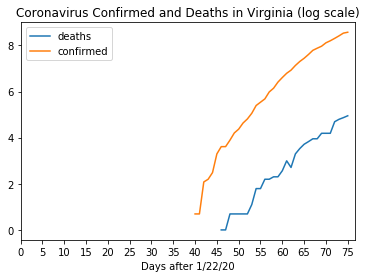

In [55]:
vaconfirm = virginia_confirmed.iloc[:,12:]
vatime = virginia_deaths.iloc[:,12:]
x = vatime.columns
y = vatime.iloc[0]
x1 = vaconfirm.columns
y2 = vaconfirm.iloc[0]
fig, ax = plt.subplots()
out1 = ax.plot(x,np.log(y), label = 'deaths')
out2 = ax.plot(x1,np.log(y2), label = 'confirmed')
out3 = ax.set_title("Coronavirus Confirmed and Deaths in Virginia (log scale)")
out4 = ax.set_xticks(np.arange(0,len(x),5))
out5 =ax.set_xticklabels(np.arange(0,len(x),5))
out5 = ax.set_xlabel("Days after 1/22/20")
ax.legend()
plt.show()

In [59]:
virginia_geo = deaths_df[deaths_df.Province_State == 'Virginia']
gdf = geopandas.GeoDataFrame(
    virginia_geo, geometry=geopandas.points_from_xy(virginia_geo.Long_, virginia_geo.Lat))
gdf = gdf[gdf.Lat != 0]
virginia_geo_confirm = confirmed_df[confirmed_df.Province_State == 'Virginia']
gdf2 = geopandas.GeoDataFrame(
    virginia_geo_confirm, geometry=geopandas.points_from_xy(virginia_geo_confirm.Long_, virginia_geo_confirm.Lat))
gdf2 = gdf2[gdf2.Lat != 0]
confirm_per_city = gdf2.iloc[:,12:].sum(axis = 1)
states = geopandas.read_file('map_data.json')
virginia_geo = states[states.NAME == 'Virginia']
deaths_per_city = gdf.iloc[:,12:].sum(axis = 1)

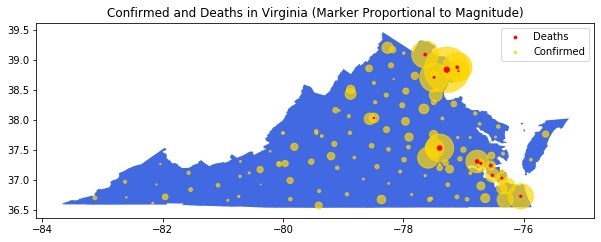

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
virginia_geo.plot(ax = ax, color = 'royalblue')
gdf.plot(ax=ax, color = 'red', marker = '.', markersize = deaths_per_city, zorder =2, label = 'Deaths')
gdf2.plot(ax=ax, color = 'gold', marker = '.', markersize = confirm_per_city, label = 'Confirmed', alpha = 0.7)
ax.set_title("Confirmed and Deaths in Virginia (Marker Proportional to Magnitude)")
lgnd = ax.legend()
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.show()